<a href="https://colab.research.google.com/github/w4bo/teaching-bigdata/blob/main/notebooks/meta_data_management.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup the environment and the dependencies

In [6]:
%pip install sklearn
%pip install pandas
%pip install prov[dot]
%pip install numpy
%pip install seaborn

import pandas as pd
import sklearn as sk
import numpy as np
import seaborn as sns
import prov

print(pd.__version__)
print(sk.__version__)
print(np.__version__)
print(sns.__version__)
print(prov.__version__)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
1.3.5
1.0.2
1.21.6
0.11.2
2.0.0


Import the dataset. In this case, there is no need for ETL/integration since the dataset is ready for elaboration.

In [7]:
df = pd.read_csv("https://raw.githubusercontent.com/w4bo/handsOnDataPipelines/main/01-MachineLearning/datasets/housing.csv").drop(["ocean_proximity"], axis=1)
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0
...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0


Let's take a look at the data

In [8]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


There are some missing values in the column `total_bedorooms` what can we do?

In [9]:
# Let's create some dataset variation
# dataset1: drop the rows containing the null values and the columns `latitude` and `longitude` 
dataset_v1 = df.copy(deep=True).dropna().drop(["longitude", "latitude"], axis=1)

# dataset2: impute missing values with the average number of bedrooms 
dataset_v2 = df.copy(deep=True)
dataset_v2["total_bedrooms"] = dataset_v2["total_bedrooms"].fillna(dataset_v2["total_bedrooms"].mean())

# Create the list of datasets
datasets = [(dataset_v1, "datasetv1"), (dataset_v2, "datasetv2")]

In [10]:
# Let's import some machine learning models (here we are not addressing hyper-parameter tuning)
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

dt = DecisionTreeRegressor(random_state=0) # initialize decision tree regressor model
lr = LinearRegression() # initialize a linear regressor model

# Create the list of algorithms
ml_algorithms = [(lr, "lr"), (dt, "dt")]

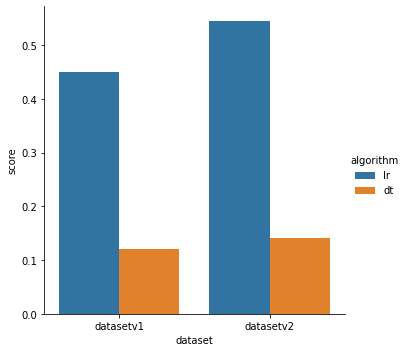

In [11]:
from sklearn.model_selection import cross_val_score

instances = []
i = 0

# For each dataset version...
for dataset, dataset_version in datasets:
  # Get the feature matrix
  X = dataset.drop(columns=["median_house_value"]).to_numpy()
  # Get the train label array
  y = dataset["median_house_value"].to_numpy() 
  
  # For each machine learning algorithm...
  for ml_algorithm, ml_algorithm_version in ml_algorithms:
    # Run the machine learning algorithm on the given dataset
    # Each run is a pipeline instance that we shoul compare against the others
    instance = {}
    instance["id"] = i # store the id of the instance 
    instance["dataset"] = dataset_version # store the version of the dataset
    instance["algorithm"] = ml_algorithm_version # store the version of the ml algorithm
    instance["score"] = cross_val_score(ml_algorithm, X, y, cv=10).mean() # store the performance of the pipeline instance
    instances = instances + [instance]
    i += 1

# Collect the results
result = pd.DataFrame.from_dict(instances, orient='columns')
sns.catplot(x = "dataset", y = "score", hue = "algorithm", data = result, kind = "bar")

And what about data provenance?

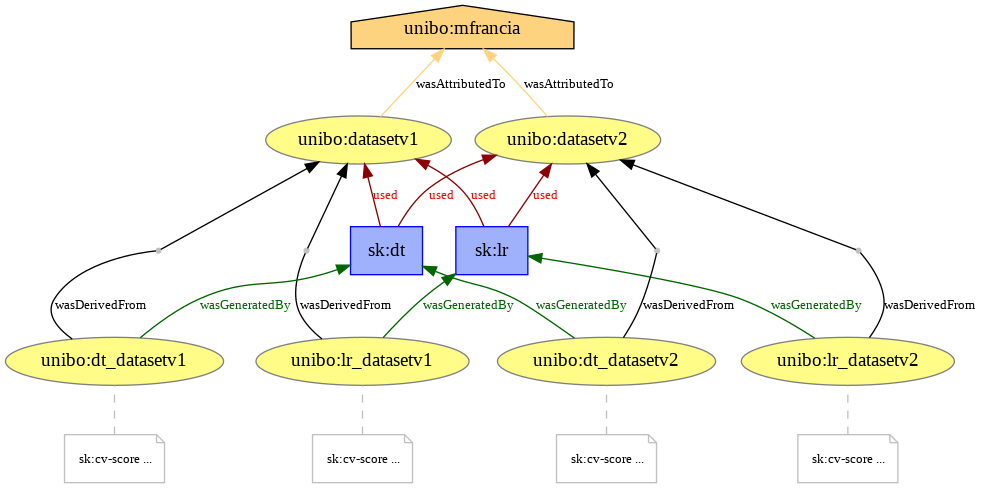

In [12]:
from prov.model import ProvDocument
from prov.dot import prov_to_dot
from IPython.display import Image

# Create a new provenance document
d1 = ProvDocument()  # d1 is now an empty provenance document
d1.add_namespace('unibo', 'https://www.unibo.it')  # add the namespace
d1.add_namespace('sk', 'https://scikit-learn.org/stable/')  # add the namespace
agent = d1.agent('unibo:mfrancia')  # add an agent

# For each dataset version...
for dataset, dataset_version in datasets:
  original_dataset = d1.entity('unibo:' + dataset_version)  # register the dataset
  d1.wasAttributedTo(original_dataset, agent)  # attribute the dataset to the agent who created it
  # For each machine learning algorithm...
  for ml_algorithm, ml_algorithm_version in ml_algorithms:
    algo = d1.activity('sk:' + ml_algorithm_version)  # register the algorithm as a (processing) activity
    processed_dataset = d1.entity('unibo:' + ml_algorithm_version + "_" + dataset_version, {'sk:cv-score': '...'})  # create an activity represented the processed dataset
    d1.used(algo, original_dataset)  # the activity used the dataset as input
    d1.wasGeneratedBy(processed_dataset, algo)  # the processed dataset has been created by the algorithm
    d1.wasDerivedFrom(processed_dataset, original_dataset)  # the processed dataset has been derived from the original one

# visualize the graph
dot = prov_to_dot(d1)
dot.write_png('prov.png')
Image('prov.png')